# Building Blocks

> Building Block related functions

In [ ]:
#| default_exp building_blocks

In [ ]:
#| hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import chem_templates
from chem_templates.imports import *
from chem_templates.utils import *
from chem_templates.chem import to_mol, to_smile, Molecule

from chem_templates.synt_on.src.SyntOn_BBs import mainSynthonsGenerator
from chem_templates.synt_on.src.SyntOn_Classifier import BBClassifier

from rdkit import Chem
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem import Draw

from __future__ import annotations

FUSION_REACTION_PATH = chem_templates.__path__[0] + '/synt_on/fusion_reactions'

/home/dmai/miniconda3/envs/chem_templates/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| export

def smile_to_synthon(smile: str, 
                     keep_pg: bool=False) -> Tuple[list[str], list[list[str]]]:
    classes = BBClassifier(mol=to_mol(smile))
    
    azoles,fSynt = mainSynthonsGenerator(smile, keep_pg, classes, returnBoolAndDict=True)

    smiles = list(fSynt.keys())
    rxns = list(fSynt.values())
    rxns = [list(i) for i in rxns]
    return smiles, rxns

In [ ]:
smile = 'CCOC(=O)c1c(N)sc2c1CCN(C)C2'
synthons, rxn_tags = smile_to_synthon(smile)
synthons[0]

'CN1CCc2c(sc([NH2:20])c2C(=O)O)C1'

In [ ]:
synthons

['CN1CCc2c(sc([NH2:20])c2C(=O)O)C1',
 'CN1CCc2c(sc([NH2:40])c2C(=O)O)C1',
 'CN1CCc2c(sc([NH2:20])c2[CH:10]=O)C1',
 'CN1CCc2c(sc([NH2:40])c2[CH:10]=O)C1']

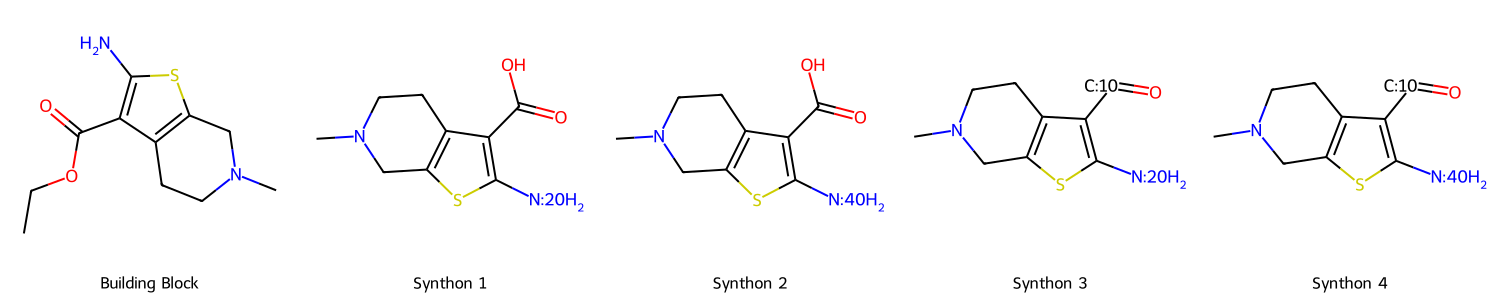

In [ ]:
Draw.MolsToGridImage([to_mol(smile)] + [to_mol(i) for i in synthons], molsPerRow=5,
                         subImgSize=(300,300), legends=['Building Block'] + [f'Synthon {i}' for i in range(1,5)])

In [ ]:
#| export

def get_synthon_marks(smile: str) -> list[str]:
    pat = re.compile("\[\w*:\w*\]")
    current_marks = deduplicate_list([smile[m.start() + 1] + ":" + smile[m.end() - 3:m.end() - 1]
            for m in re.finditer(pat, smile)])
    return current_marks

In [ ]:
get_synthon_marks(synthons[3])

['N:40', 'C:10']

In [ ]:
#| export

SYNTHON_VALID_COMBINATIONS = {'C:10': ['N:20', 'O:20', 'C:20', 'c:20', 'n:20', 'S:20'],
                                    'c:10': ['N:20', 'O:20', 'C:20', 'c:20', 'n:20', 'S:20'],
                                    'c:20': ['N:11', 'C:10', 'c:10'], 'C:20': ['C:10', 'c:10'],
                                    'c:21': ['N:20', 'O:20', 'n:20'], 'C:21': ['N:20', 'n:20'],
                                    'N:20': ['C:10', 'c:10', 'C:21', 'c:21', 'S:10'], 'N:11': ['c:20'],
                                    'n:20': ['C:10', 'c:10', 'C:21', 'c:21'], 'O:20': ['C:10', 'c:10', 'c:21'],
                                    'S:20': ['C:10', 'c:10'], 'S:10': ['N:20'], 'C:30': ['C:40', 'N:40'],
                                    'C:40': ['C:30'], 'C:50': ['C:50'], 'C:70': ['C:60', 'c:60'],
                                    'c:60':['C:70'], 'C:60': ['C:70'], 'N:40': ['C:30'] }

def prep_for_reconstruction(smile: str) -> str:
    # augments synthon annotations (ie c:10) with dummy atoms for fusion
    labels = [10, 20, 30, 40, 50, 60, 70, 21, 11] # annotation numbers
    atomsForMarking = [23, 74, 72, 104, 105, 106, 107, 108, 109] # dummy atoms
    atomsForMarkingForDoubleBonds = [72, 104, 105]
    
    mol = to_mol(smile)
    mol = Chem.AddHs(mol)
    
    for atom in mol.GetAtoms():
        if atom.GetAtomMapNum() != 0:
            repl = atomsForMarking[labels.index(atom.GetAtomMapNum())]
            replCount = 0
            for neighbor in atom.GetNeighbors():
                if neighbor.GetAtomicNum() == 1:
                    mol.GetAtomWithIdx(neighbor.GetIdx()).SetAtomicNum(repl)
                    replCount += 1
                    if repl not in atomsForMarkingForDoubleBonds and replCount == 1:
                        break
                    elif replCount == 2:
                        break
                        
    mol = Chem.RemoveHs(mol)
    return to_smile(mol)

def remove_reconstruction_marks(smile: str) -> str:
    # removes dummy atoms for fusion
    atomsForMarking = set([23, 74, 72, 104, 105, 106, 107, 108, 109])
    mol = to_mol(smile)
    
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() in atomsForMarking:
            atom.SetAtomicNum(1)
            
    mol = Chem.AddHs(mol)
    mol = Chem.RemoveHs(mol)
            
    return to_smile(mol)

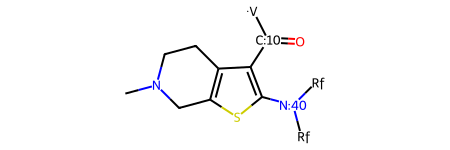

In [ ]:
for_recon = prep_for_reconstruction(synthons[3])
assert remove_reconstruction_marks(for_recon) == synthons[3]
to_mol(for_recon)

In [ ]:
#| export

class BuildingBlock(Molecule):
    def __init__(self, 
                 smile:          str, 
                 synthon_smiles: Optional[list[str]]=None,
                 reaction_tags:  Optional[list[str]]=None,
                 data:           Optional[dict]=None):
        super().__init__(smile, data)
        
        self.synthons = []
        
        if synthon_smiles is None:
            synthon_smiles, reaction_tags = smile_to_synthon(smile)
        
        for synthon_smile, reaction_tags in zip(synthon_smiles, reaction_tags):
            recon_smile = prep_for_reconstruction(synthon_smile)
            synthon = Synthon(synthon_smile, recon_smile, [self], list(reaction_tags), None)
            self.synthons.append(synthon)
    
class Synthon(Molecule):
    def __init__(self, 
                 synthon_smile:        str, 
                 reconstruction_smile: str, 
                 parents:              list[Molecule], 
                 reaction_tags:        list[str], 
                 data:                 Optional[dict]=None):
        
        # synthon smile used for template
        # reconstruction smile used for fusing
        super().__init__(synthon_smile, data)
        self.parents = parents
        self.reaction_tags = reaction_tags
        
        self.reconstruction_smile = reconstruction_smile
        self.reconstruction_mol = to_mol(reconstruction_smile)
        
        self.marks = set(get_synthon_marks(self.reconstruction_smile))
        self.compatible_marks = set(flatten_list([SYNTHON_VALID_COMBINATIONS[i] for i in self.marks]))
        
    def is_compatible(self, synthon):
        overlaps = self.compatible_marks.intersection(synthon.marks)
        return bool(overlaps)

In [ ]:
smile1 = 'CCOC(=O)c1n[nH]c2c1CN(C(=O)NCN=C=O)CC2'
bb1 = BuildingBlock(smile1)

smile2 = 'CCOC(=O)c1c(N)sc2c1CCN(C)C2'
bb2 = BuildingBlock(smile2)

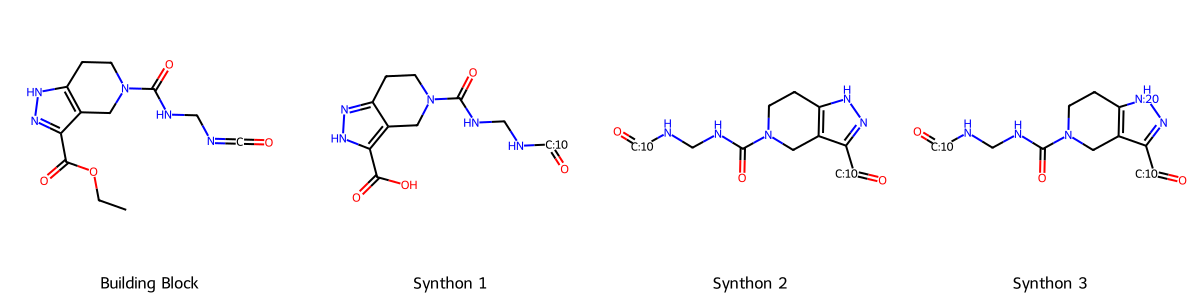

In [ ]:
Draw.MolsToGridImage([bb1.mol] + [i.mol for i in bb1.synthons], molsPerRow=4,
                         subImgSize=(300,300), legends=['Building Block'] + [f'Synthon {i}' for i in range(1,4)])

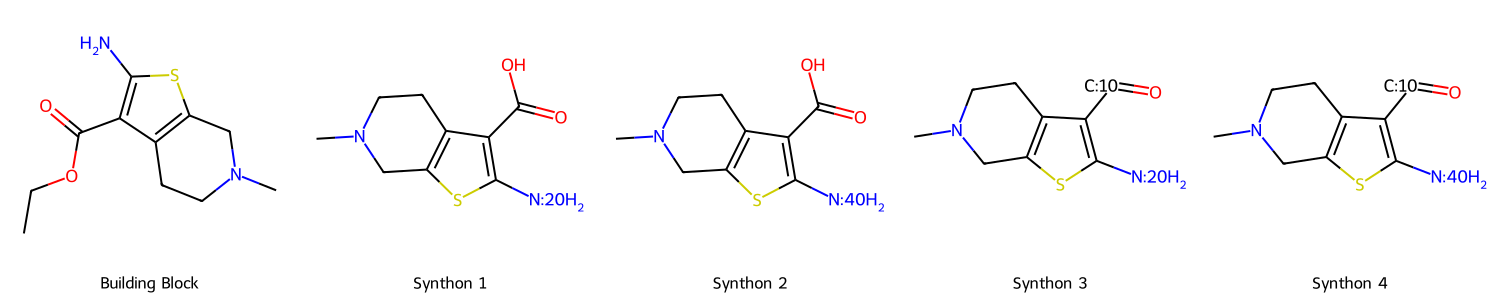

In [ ]:
Draw.MolsToGridImage([bb2.mol] + [i.mol for i in bb2.synthons], molsPerRow=5,
                         subImgSize=(300,300), legends=['Building Block'] + [f'Synthon {i}' for i in range(1,5)])

In [ ]:
assert bb1.synthons[0].is_compatible(bb2.synthons[0])

In [ ]:
#| export

class FusionReaction():
    def __init__(self, name: str, rxn_smarts: str):
        self.name = name
        self.rxn_smarts = rxn_smarts
        self.rxn = Reactions.ReactionFromSmarts(rxn_smarts)
        self.rxn.Initialize()
        
    def is_reactant(self, synthon1: Synthon, synthon2: Optional[Synthon]=None) -> bool:
        output = self.rxn.IsMoleculeReactant(synthon1.reconstruction_mol)
        if synthon2 is not None:
            output = output and self.rxn.IsMoleculeReactant(synthon2.reconstruction_mol)
            
        return output
    
    def react(self, synthon1: Synthon, synthon2: Synthon) -> list[Synthon]:
        products = self.rxn.RunReactants((synthon1.reconstruction_mol, 
                                          synthon2.reconstruction_mol))
        if not products:
            products = self.rxn.RunReactants((synthon2.reconstruction_mol, 
                                          synthon1.reconstruction_mol))

        if products:
            products = flatten_list(products)
        else:
            products = []
            
        outputs = []
        for product in products:
            recon_smile = to_smile(product)
            synthon_smile = remove_reconstruction_marks(recon_smile)
            result = Synthon(synthon_smile, recon_smile, [synthon1, synthon2], [self.name], None)
            outputs.append(result)
            
        return outputs
    
    def __repr__(self):
        return f'Reaction: {self.name}'

In [ ]:
rxn_smarts = '[#6;!D1;$([#6]=[#8]);!$([#6]([#6])=[#8]):1][#23:3].[#7;A;+0;!D1;!$([#7]=[#7]):2][#74:4]>>[#6:1]-[#7:2]'
rxn_name = 'N-Acylation by O=C(+)-X reagents (except isocyanates - R1.4)'

rxn = FusionReaction(rxn_name, rxn_smarts)

assert rxn.is_reactant(bb1.synthons[0], bb2.synthons[0])

products = rxn.react(bb1.synthons[0], bb2.synthons[0])
assert len(products)==1
assert products[0].smile == 'CN1CCc2c(sc(NC(=O)NCNC(=O)N3CCc4n[nH]c(C(=O)O)c4C3)c2C(=O)O)C1'

In [ ]:
#| export

class ReactionGroup():
    # holds reactions beloning to the same type of transform
    def __init__(self, name: str, reactions: list[FusionReaction]):
        self.name = name
        self.reactions = reactions
        
    def get_matching_reactions(self, synthon1: Synthon, 
                               synthon2: Optional[Synthon]=None) -> list[FusionReaction]:
        return [i for i in self.reactions if i.is_reactant(synthon1, synthon2)]
    
    def dump(self) -> dict:
        output = {
            'name' : self.name,
            'reactions' : [
                {'name' : i.name, 'smarts' : i.rxn_smarts} for i in self.reactions
            ]
        }
        return output
        
    @classmethod
    def from_dict(cls, input_dict: dict) -> ReactionGroup:
        reactions = [FusionReaction(i['name'], i['smarts']) for i in input_dict.get('reactions', [])]
        return cls(input_dict['name'], reactions)
    
    @classmethod
    def from_file(cls, filename: str) -> ReactionGroup:
        with open(filename, 'r') as f:
            input_dict = json.load(f)
            return cls.from_dict(input_dict)
    
    def __repr__(self):
        return f'Reaction Class: {self.name}' + '\n\t'.join([i.__repr__() for i in self.reactions])

In [ ]:
#| export

REACTION_GROUP_NAMES = ['O-acylation',
 'Olefination',
 'Condensation_of_Y-NH2_with_carbonyl_compounds',
 'Amine_sulphoacylation',
 'C-C couplings',
 'Radical_reactions',
 'N-acylation',
 'O-alkylation_arylation',
 'Metal organics C-C bong assembling',
 'S-alkylation_arylation',
 'Alkylation_arylation_of_NH-lactam',
 'Alkylation_arylation_of_NH-heterocycles',
 'Amine_alkylation_arylation']

REACTION_GROUPS = [ReactionGroup.from_file(f'{FUSION_REACTION_PATH}/{i}.json') for i in REACTION_GROUP_NAMES]
REACTION_GROUP_DICT = {i.name : i for i in REACTION_GROUPS}

In [ ]:
compatible_reactions = flatten_list([i.get_matching_reactions(bb1.synthons[0]) for i in REACTION_GROUPS])
assert len(compatible_reactions) == 9

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()